Transfer Learning has 2 types.
1. Feature Extraction
2. Fine Tunning

This code is for Type 1: Feature Extraction.
In Feature Extraction, We freeze the training of conv_base part of the pre-trained model and we build the a model with same conv_base and keeping different FC layer(ANN part).

Code will consist of 2 Type of Techniques.
1. Feature Extraction without Data Augmentation
2. Feature Extraction with Data Augmentation.

Dataset used will be a Cats Vs Dogs Classifier data from Kaggle.com
and the pretrainned model we will be using is VGG16

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d salader/dogs-vs-cats

 99% 1.05G/1.06G [00:03<00:00, 254MB/s]
100% 1.06G/1.06G [00:04<00:00, 283MB/s]


In [3]:
import zipfile
zip = zipfile.ZipFile('/content/dogs-vs-cats.zip')
zip.extractall('/content')
zip.close()

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16

# VGG15 Architecture

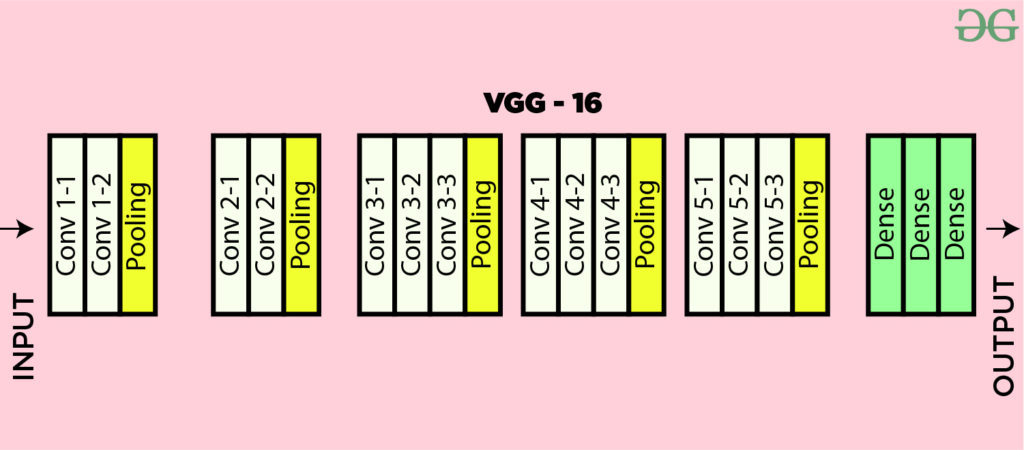

In [5]:
## Initialising a Pre-trained Model

conv_base = VGG16( weights = 'imagenet',
                  include_top= False,   # Top is consider as FC Layer(ANN Part) which we donot want to include
                  input_shape = (150,150,3))

conv_base.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

As we can see the last layer is Block5- maxpooling layer. So we have removed the FC Layer from the architecture.

In [16]:
## Build Our Own Model

model = Sequential()

# Adding the conv part of pretrained Model and do flattening to prepare it as input to ANN part

model.add(conv_base)
model.add(Flatten())

# Defining Our own FC Layer (ANN Part)

model.add(Dense(256, activation = 'relu')) # Only 1 Hidden layer with 256 neuron
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 2097665 (8.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


Observe the Trainable paramertes as 16,812,353 (>16M)

In [17]:
# During Training we Freeze the conv_base part, that mean we donot retrain the weights of conv_base

conv_base.trainable = False

# At this point let check trainable parameters

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 2097665 (8.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


As we observe the trainable parameters are now 2,097,665 (2M) so that by freezing the training of weights of conv_base part the traininable parameters are reduced to 2M from 16M (>80%) reduction.

# Transfer Learning (Type 1: Feature Extraction) without Data Augmentation.

In [8]:
# Generator

train_ds = keras.utils.image_dataset_from_directory(
    directory= '/content/train',
    labels= 'inferred',
    label_mode= 'int', # Output Class Label Encoding,Cats = 0, Dogs = 1 (as cats is the first label in the directory
    batch_size= 32,                                                      # and it starts from 0)
    image_size=(150,150))

validation_ds = keras.utils.image_dataset_from_directory(
    directory= '/content/test',
    labels= 'inferred',
    label_mode= 'int', # Output Class Label Encoding,Cats = 0, Dogs = 1 (as cats is the first label in the directory
    batch_size= 32,                                                       # and it starts from 0)
    image_size=(150,150))

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [9]:
# Normalization

def normalize(image, label):

  image = tf.cast(image/255.0, tf.float64 )

  return image, label

train_ds = train_ds.map(normalize)
validation_ds = validation_ds.map(normalize)

In [10]:
# Compiling the Model

model.compile(optimizer='adam', loss = 'binary_crossentropy',metrics = ['accuracy'])

In [11]:
## Training the Model

history = model.fit(train_ds, epochs=10, validation_data = validation_ds)

Epoch 1/10
625/625 [==============================] - 77s 103ms/step - loss: 0.2640 - accuracy: 0.8886 - val_loss: 0.2177 - val_accuracy: 0.9060
Epoch 2/10
625/625 [==============================] - 55s 87ms/step - loss: 0.1873 - accuracy: 0.9219 - val_loss: 0.2081 - val_accuracy: 0.9118
Epoch 3/10
625/625 [==============================] - 55s 88ms/step - loss: 0.1584 - accuracy: 0.9338 - val_loss: 0.1979 - val_accuracy: 0.9154
Epoch 4/10
625/625 [==============================] - 65s 103ms/step - loss: 0.1352 - accuracy: 0.9445 - val_loss: 0.2163 - val_accuracy: 0.9112
Epoch 5/10
625/625 [==============================] - 65s 104ms/step - loss: 0.1166 - accuracy: 0.9539 - val_loss: 0.2240 - val_accuracy: 0.9144
Epoch 6/10
625/625 [==============================] - 55s 88ms/step - loss: 0.0901 - accuracy: 0.9650 - val_loss: 0.2326 - val_accuracy: 0.9178
Epoch 7/10
625/625 [==============================] - 65s 103ms/step - loss: 0.0635 - accuracy: 0.9772 - val_loss: 0.2577 - val_accur

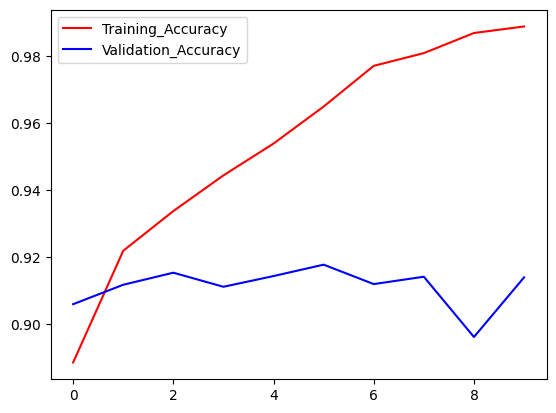

In [12]:
## Plotting the accuracy

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], color = 'red', label = 'Training_Accuracy')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'Validation_Accuracy')
plt.legend()
plt.show()

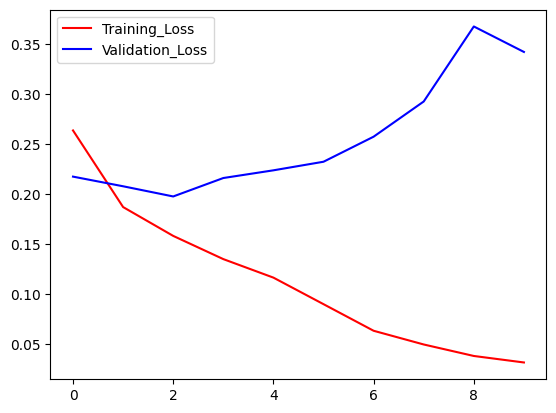

In [13]:
## Plotting the Losses

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], color = 'red', label = 'Training_Loss')
plt.plot(history.history['val_loss'], color = 'blue', label = 'Validation_Loss')
plt.legend()
plt.show()

As observed there is an Overfitting in the Model and gaps are huge.

# # Transfer Learning (Type 1: Feature Extraction) without Data Augmentation.Applying Data Augmentation to reduce Overfitting

In [15]:
from traitlets.traitlets import directional_link
from keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array

batch_size = 32

train_img_gen = ImageDataGenerator(
    rescale = 1/255.0,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range= 0.2
)

test_img_gen = ImageDataGenerator(rescale = 1/255.0)

train_ds1 = train_img_gen.flow_from_directory(
    directory = '/content/train',
    target_size = (150,150),
    batch_size = batch_size,
    class_mode='binary'

)

validation_ds1 = test_img_gen.flow_from_directory(
    directory = '/content/test',
    target_size = (150,150),
    batch_size = batch_size,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [18]:
# Compiling the Model

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [19]:
# Training the Model

history1 = model.fit(train_ds1, epochs = 10, validation_data = validation_ds1)

Epoch 1/10
625/625 [==============================] - 168s 265ms/step - loss: 0.3008 - accuracy: 0.8697 - val_loss: 0.2289 - val_accuracy: 0.8986
Epoch 2/10
625/625 [==============================] - 192s 307ms/step - loss: 0.2384 - accuracy: 0.8984 - val_loss: 0.2049 - val_accuracy: 0.9132
Epoch 3/10
625/625 [==============================] - 197s 314ms/step - loss: 0.2212 - accuracy: 0.9068 - val_loss: 0.2106 - val_accuracy: 0.9092
Epoch 4/10
625/625 [==============================] - 174s 279ms/step - loss: 0.2086 - accuracy: 0.9103 - val_loss: 0.2308 - val_accuracy: 0.9010
Epoch 5/10
625/625 [==============================] - 168s 268ms/step - loss: 0.2027 - accuracy: 0.9150 - val_loss: 0.1863 - val_accuracy: 0.9218
Epoch 6/10
625/625 [==============================] - 158s 253ms/step - loss: 0.1868 - accuracy: 0.9218 - val_loss: 0.1949 - val_accuracy: 0.9202
Epoch 7/10
625/625 [==============================] - 158s 252ms/step - loss: 0.1812 - accuracy: 0.9222 - val_loss: 0.2296 -

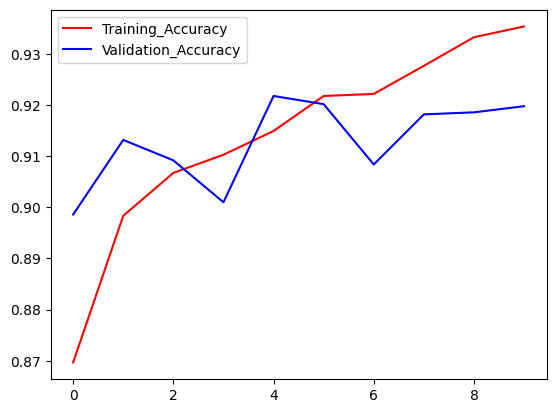

In [22]:
## Plotting the accuracy

import matplotlib.pyplot as plt

plt.plot(history1.history['accuracy'], color = 'red', label = 'Training_Accuracy')
plt.plot(history1.history['val_accuracy'], color = 'blue', label = 'Validation_Accuracy')
plt.legend()
plt.show()

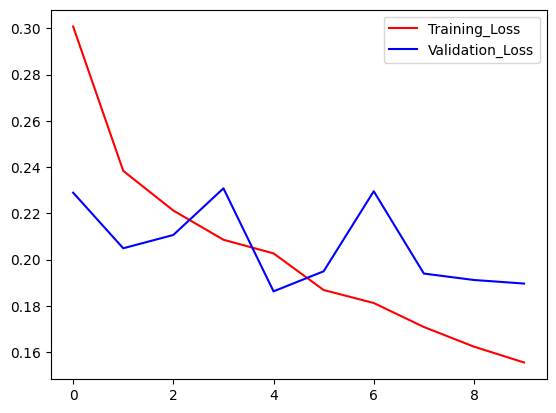

In [23]:
## Plotting the Losses

import matplotlib.pyplot as plt

plt.plot(history1.history['loss'], color = 'red', label = 'Training_Loss')
plt.plot(history1.history['val_loss'], color = 'blue', label = 'Validation_Loss')
plt.legend()
plt.show()

As we can observed the Overfitting has been reduced to a great entent using Data Augmentation